In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import astropy.units as u
from astropy.wcs import wcs
from astropy.io import fits
from scipy import ndimage
from matplotlib.gridspec import GridSpec
from tempfile import TemporaryFile

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from importlib import reload

import os
os.chdir('/Users/felix/Research/scripts/')
import functions as func

### Importing important Data:

In [2]:
img_N = fits.open('/Users/felixmartinez/Research/CANDLES/goods_data/goodsn_3dhst_v4.0_f160w/goodsn_3dhst.v4.0.F160W_orig_sci.fits')[0].data
seg_N = fits.open('/Users/felixmartinez/Research/CANDLES/goods_data/goodsn_3dhst.v4.0.F160W_seg.fits')[0].data
segN_fits = '/Users/felixmartinez/Research/CANDLES/goods_data/goodsn_3dhst.v4.0.F160W_seg.fits'
w = wcs.WCS(segN_fits)

corrected_x = np.load('/Users/felixmartinez/Research/merger_detection/Rand_Ha/corrected_x_median.npy')
corrected_y = np.load('/Users/felixmartinez/Research/merger_detection/Rand_Ha/corrected_y_median.npy')
xrange = np.linspace(-30,30, 1000)
yrange = np.linspace(-30,30, 1000)

In [3]:
#Merger Candidates

#The failed arrays do not have Ha in their fitz files
#The Bad arrays have issues with subtraction/noise that may throw the data off

GN1 = [36808,37615,37810,36514,36928,37636,37821,37006,37363,37738,37836,36651,37807,38041,
       37067,37395,37750,36717,37074,37786,37996,36736,37102,37424,37787,38027,36795,37193]
GN1_bad = [36420,37343,37957,37406]
GN1_failed = [36577]

GN2 = [10101,11429,15544,18197,20948,10336,11526,15861,21720,10512,11941,15867,18642,21854,10528,
       12479,16033,18817,21918,10619,16083,18869,22265,10639,13037,18988,14621,20298,26882,11339,
       23667,10723,16753,19592,25616,11152,14780,17139,19860,25671,11228,15050,17626,15477,17635]
GN2_bad = [18315,16173,22417,10653,14713,20701]
GN2_failed = [12499,16375,19316]

GN3 = [26922,33422,34527,36054,27018,31179,33571,36406,27101,31788,33673,36433,27422,33135,34407,
       31957,33707,36720,27472,33732,35039,28593,32329,33764,35045,37171,28596,32905,34403,35264,35617]
GN3_bad = [29641,34562,34739,34747,32066,29325]
GN3_failed = [37053,37188]

GN4 = [15999,20073,22265,25734,28596,18400,20305,23381,26696,20319,23608,27018,29641,18763,
       20481,23889,27101,32229,19437,20635,27472,19485,21564,25393,27930,19493,25687,28593]
GN4_bad = [29325,18574,23936]
GN4_failed = [21814]

GN5 = [33764]
GN5_bad = [32562]
GN5_failed = [33571]

GN7 = [10964,13777,15300,19017,19875,11683,13821,15477,21152,13909,15544,19149,12713,14178,
       15761,19235,13466,14281,17927,19270,13750,19659]
GN7_bad = [11750,14597]
GN7_failed = [19088,18642]

#All of the failed arrays have no Ha in the fits files, It also has no Ha in CLEAR so that is ok

# No Filter
When analysing the raw images for our merger objects (downloaded separetly) we can see that some of these images have a lot of background noise in them (due to these galaxies being so faint). We will be running a test keeping this noise in.

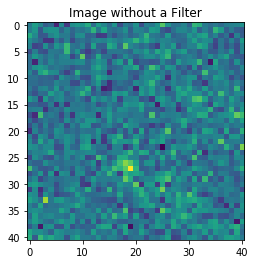

In [4]:
H_a = fits.open('/Users/felixmartinez/Research/merger_detection/candidates/merger_candidates/GN2/GN2_26882.full.fits')
Ha_fits = '/Users/felixmartinez/Research/merger_detection/candidates/merger_candidates/GN2/GN2_26882.full.fits'

Halph = []

Line = H_a['Line','Ha'].data     #Halpha data
Continuum = H_a['Continuum','Ha'].data
Contam = H_a['Contam','Ha'].data
Raw = H_a['DSCI','F105W'].data   #Original Image
    
Halph.append(Line - Continuum - Contam)  #Fixing the Errors on Halpha
Ha_img = Halph[0][20:61,20:61]

plt.imshow(Ha_img)
plt.title("Image without a Filter")
plt.show()
#plt.savefig('/Users/felixmartinez/Research/GN1_37102.png',bbox_inches = 'tight')

/Users/felixmartinez/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


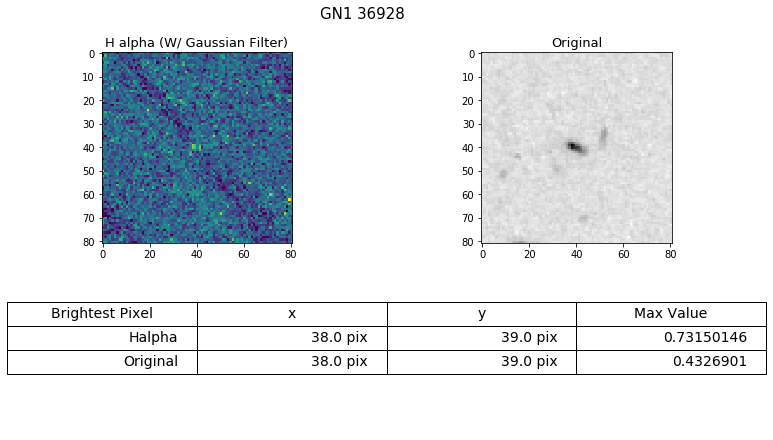

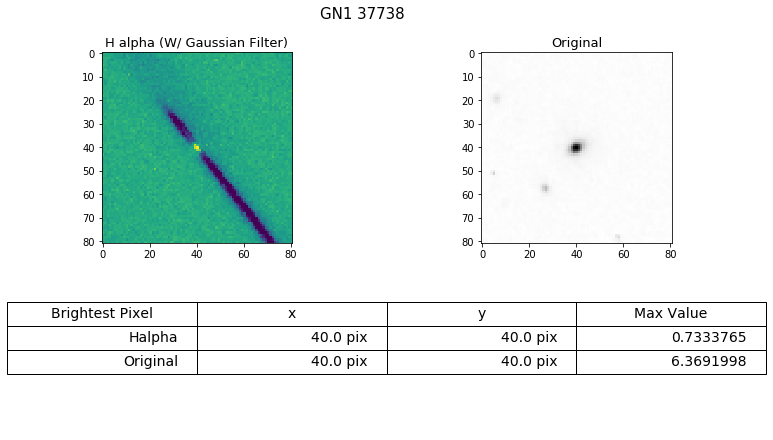

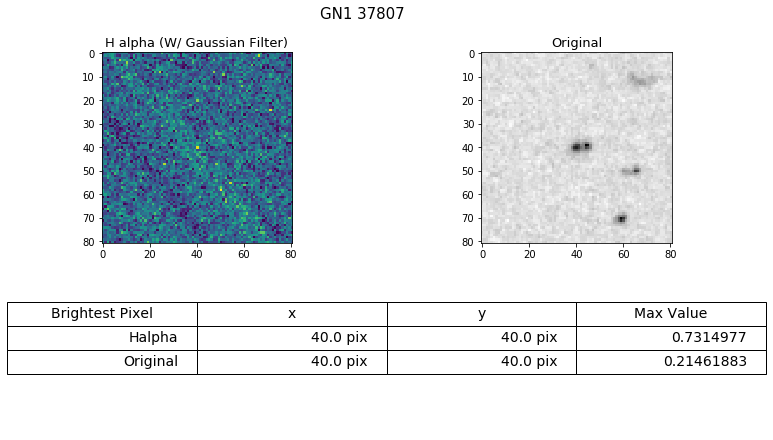

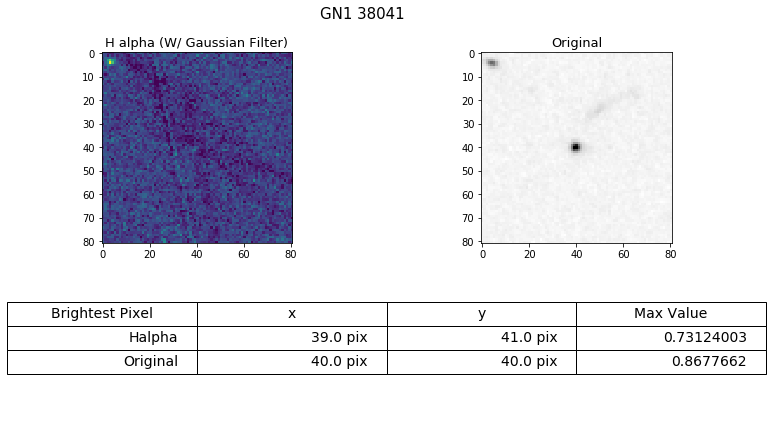

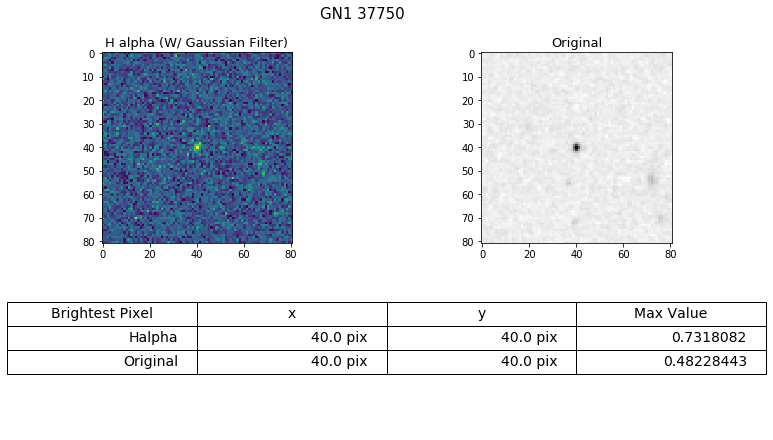

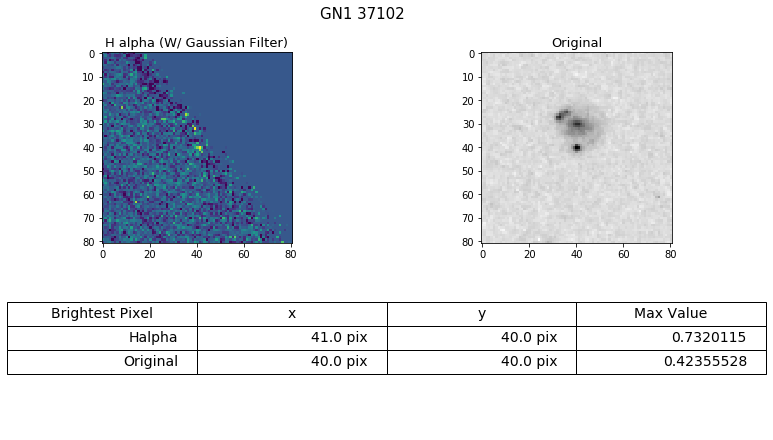

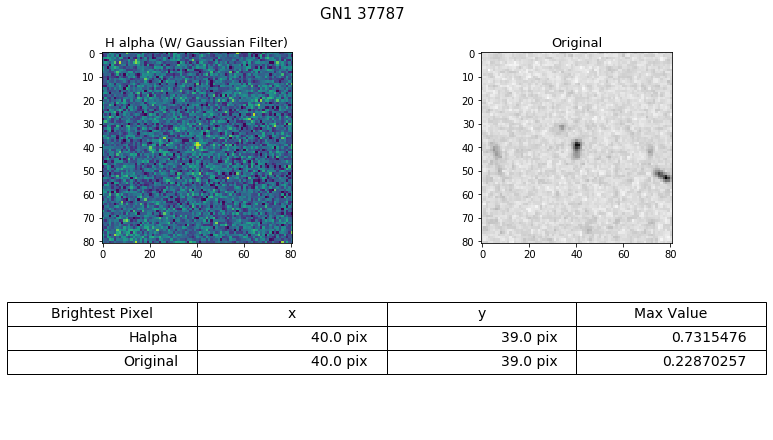

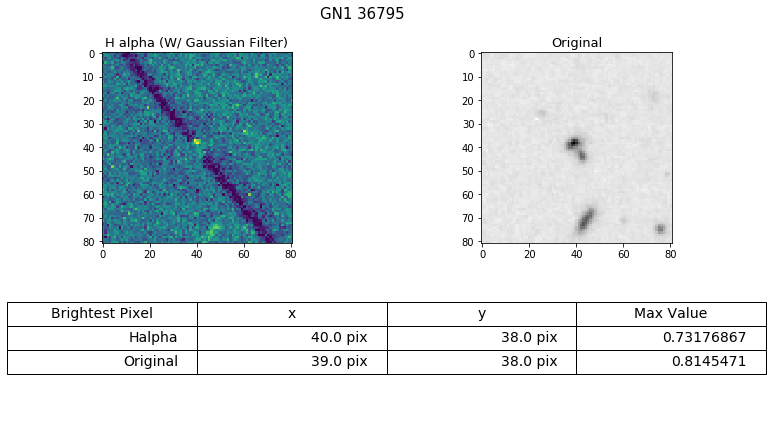

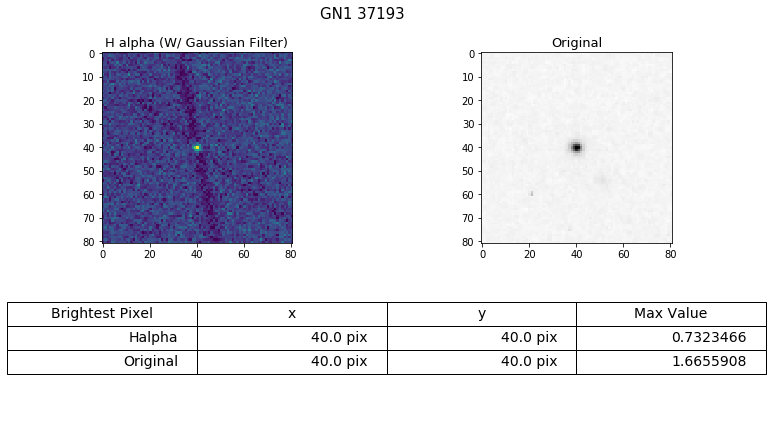

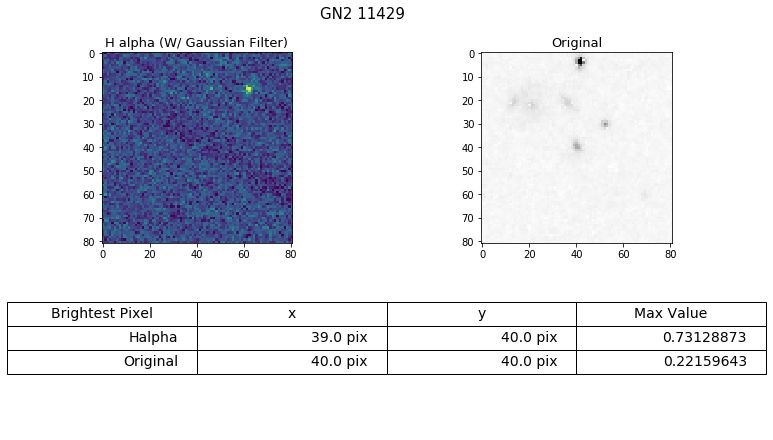

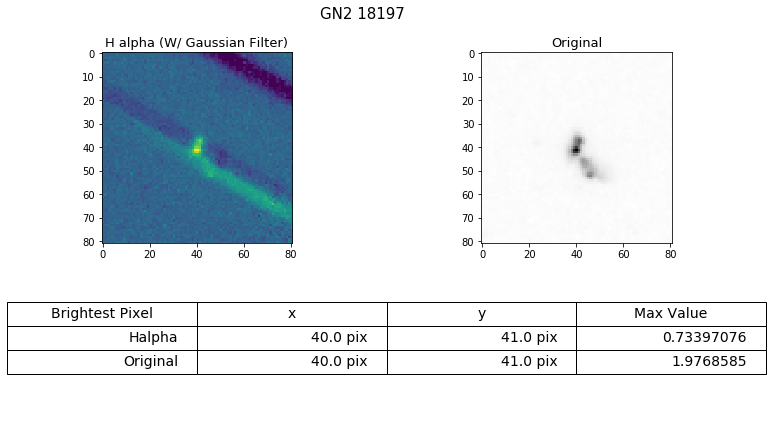

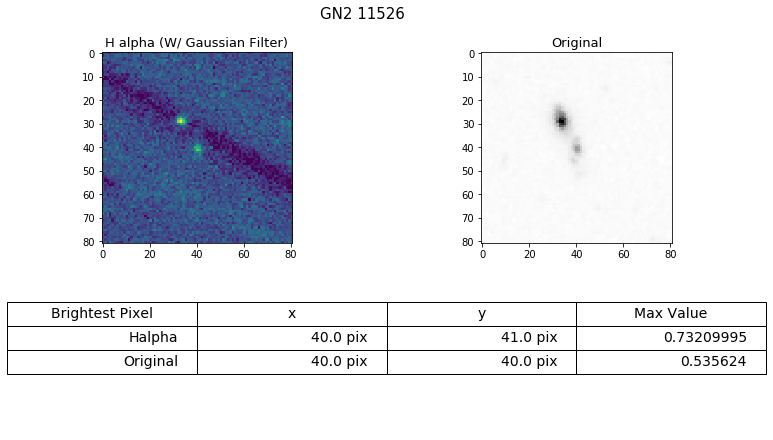

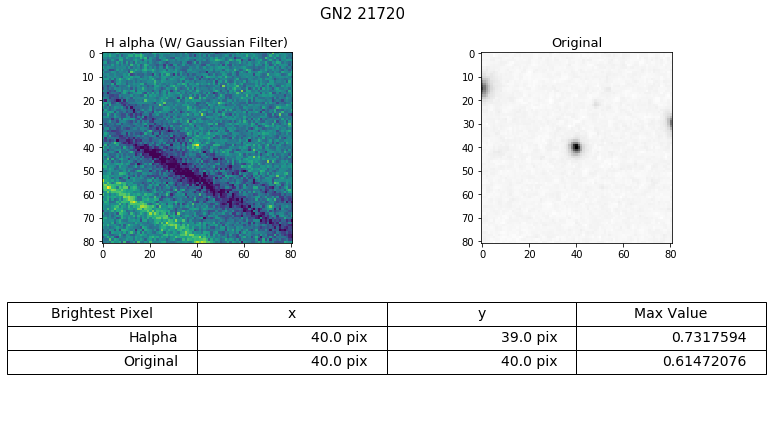

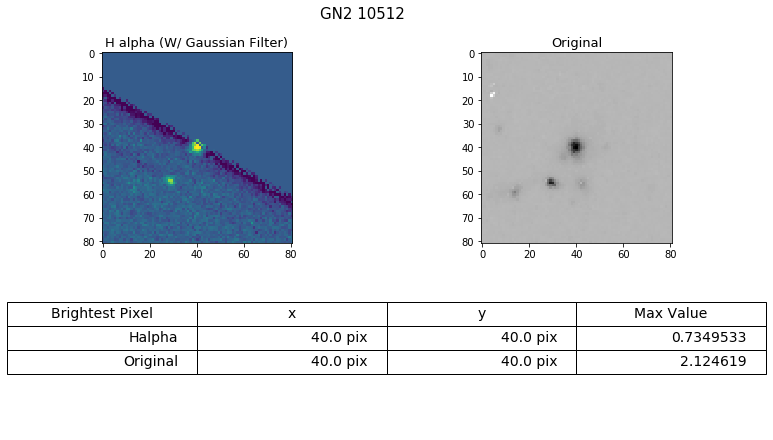

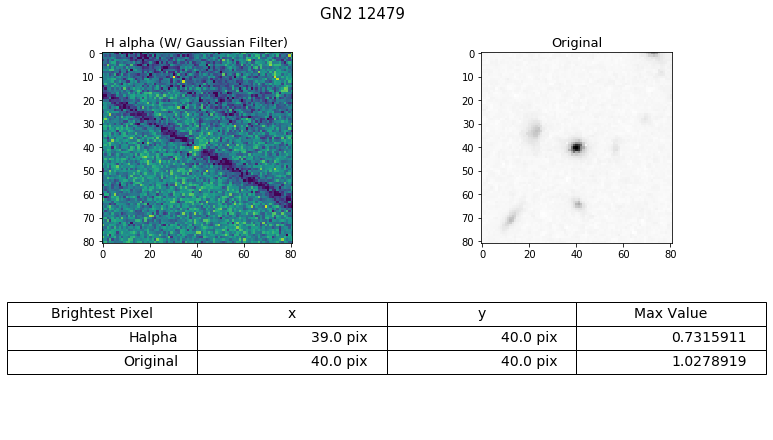

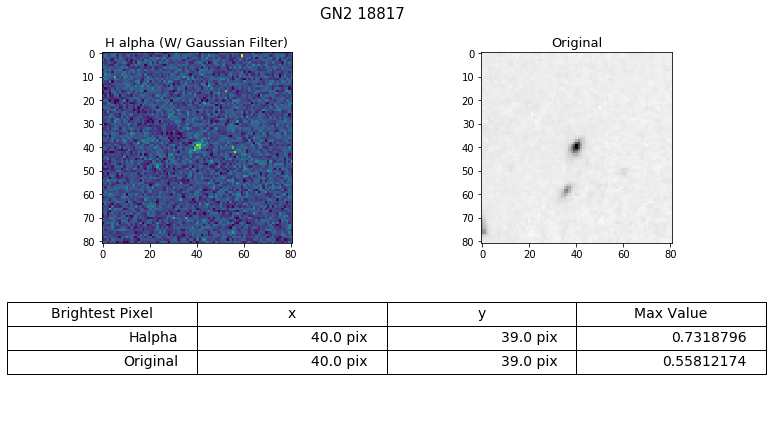

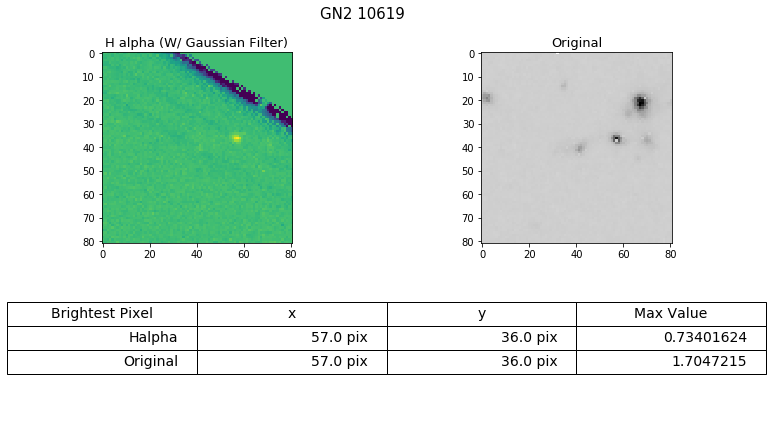

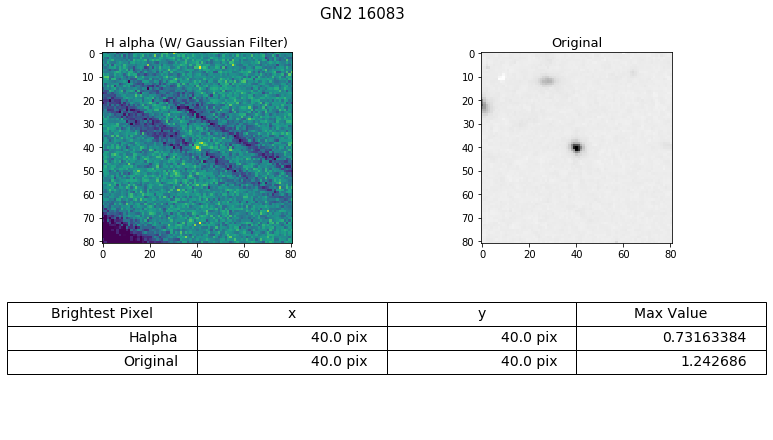

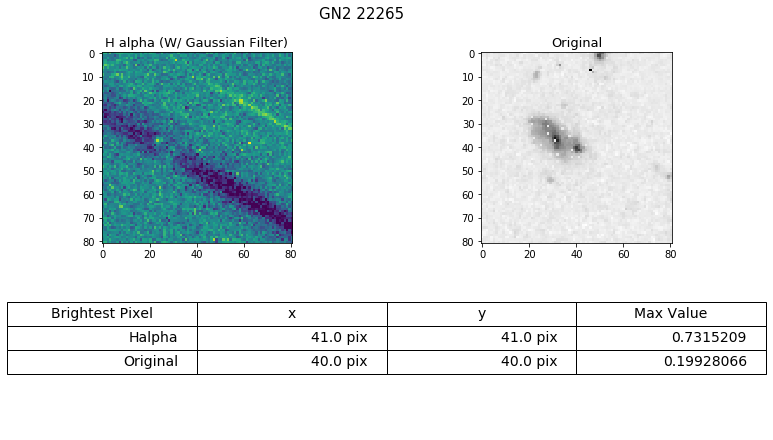

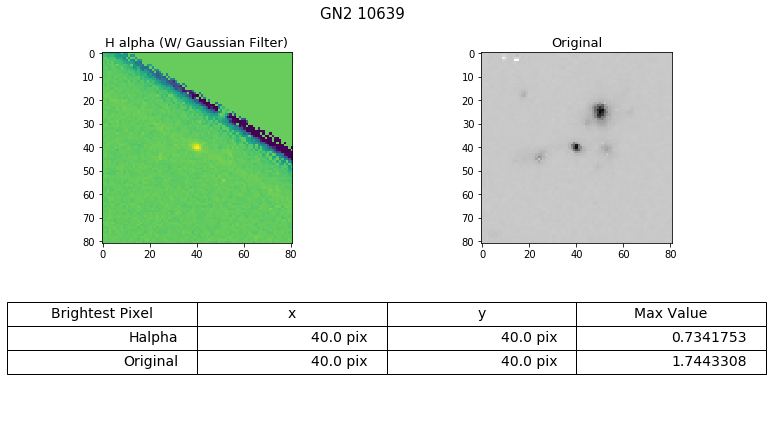

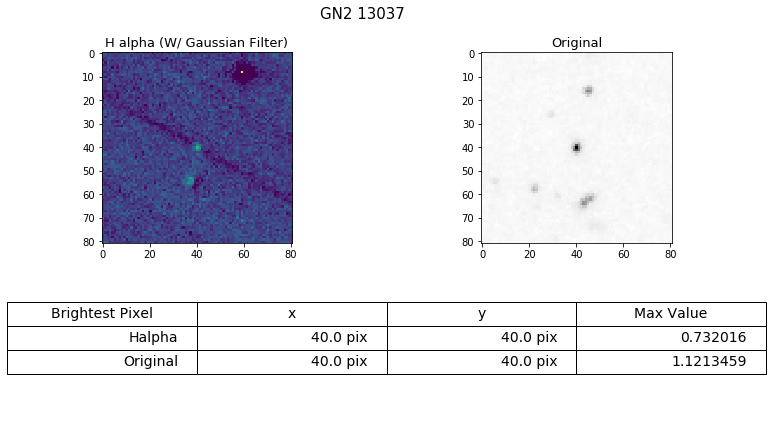

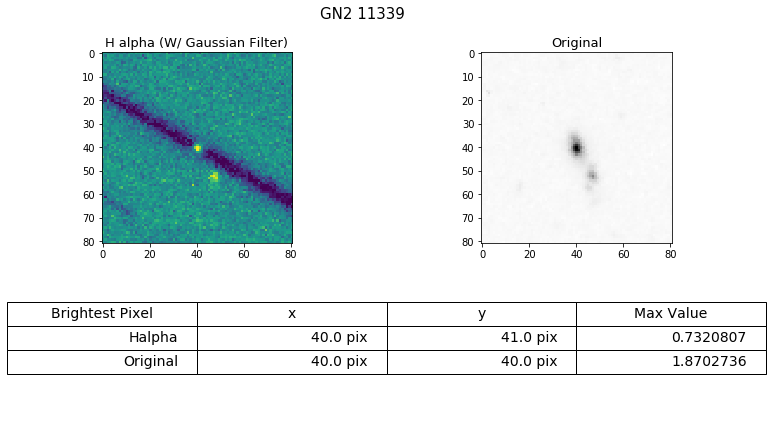

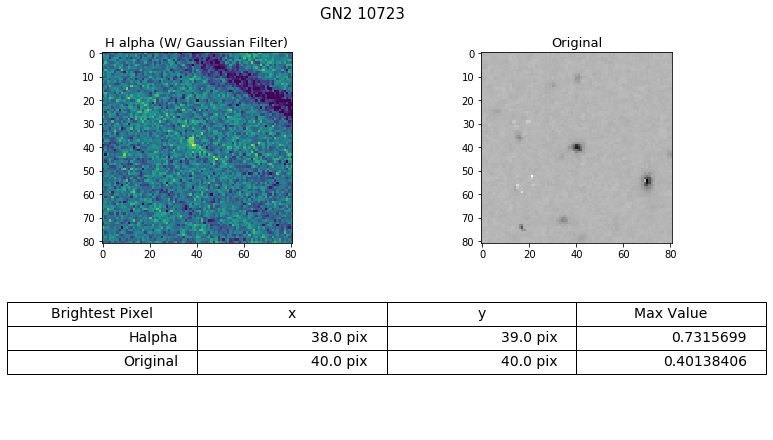

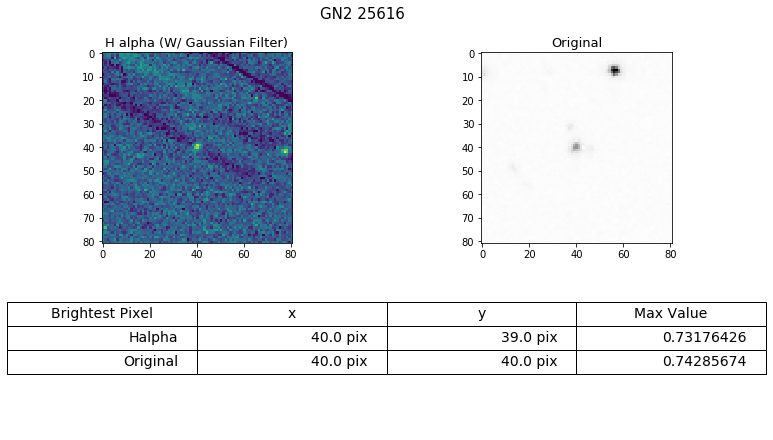

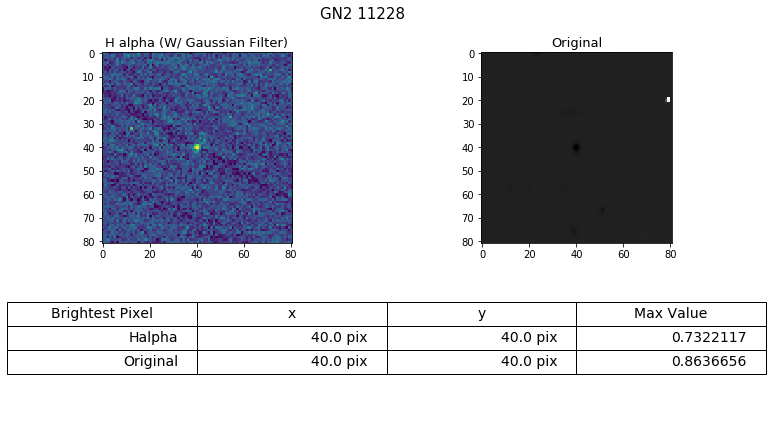

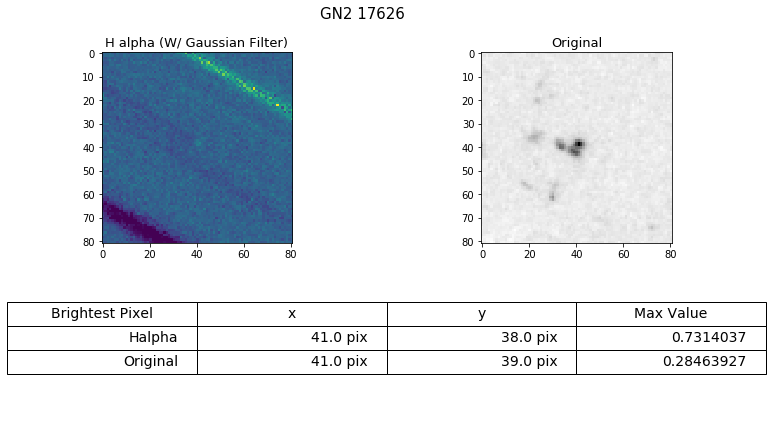

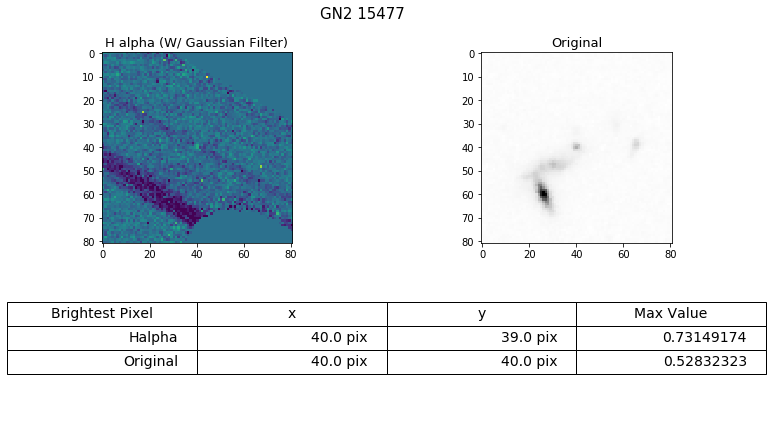

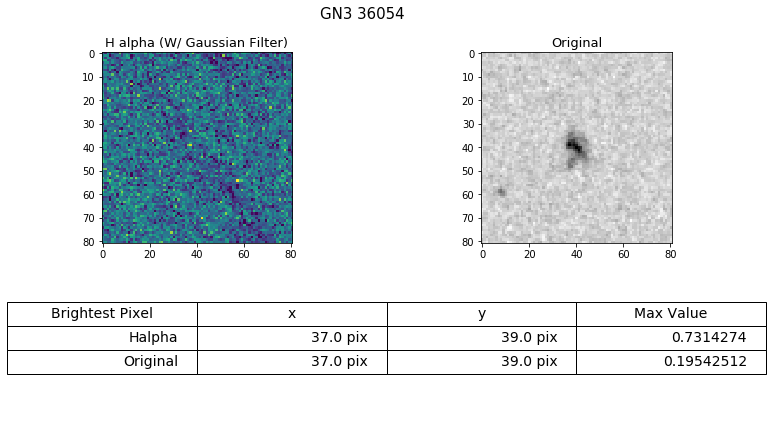

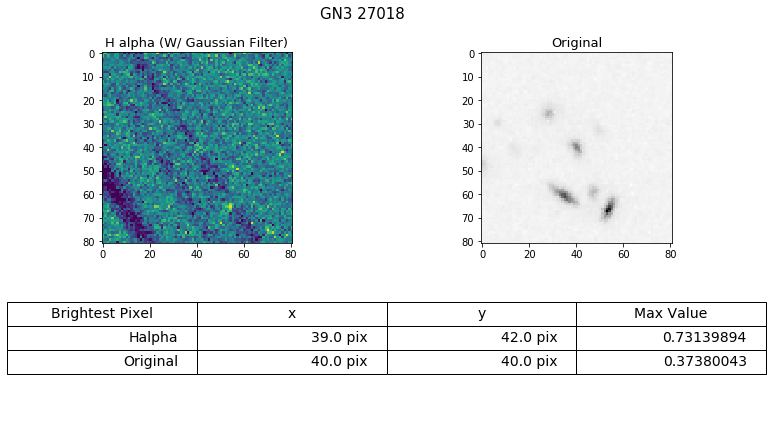

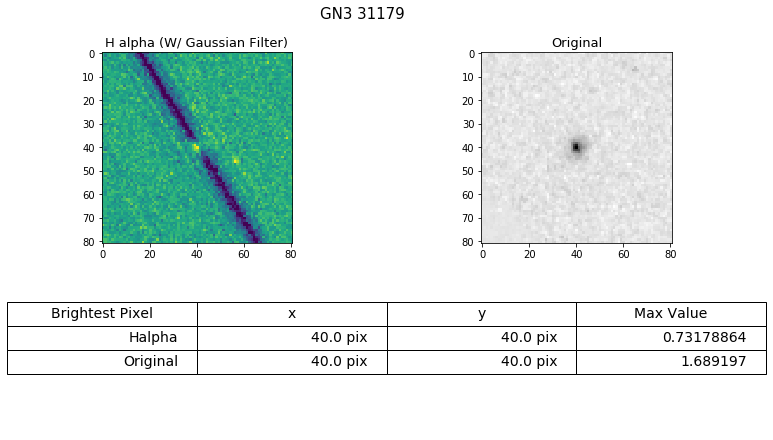

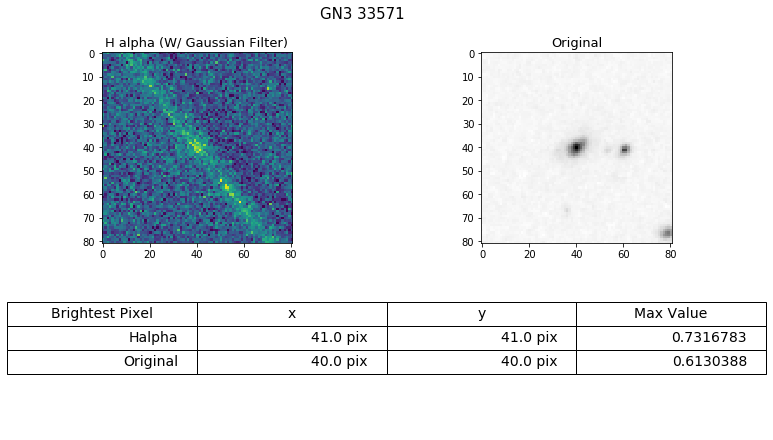

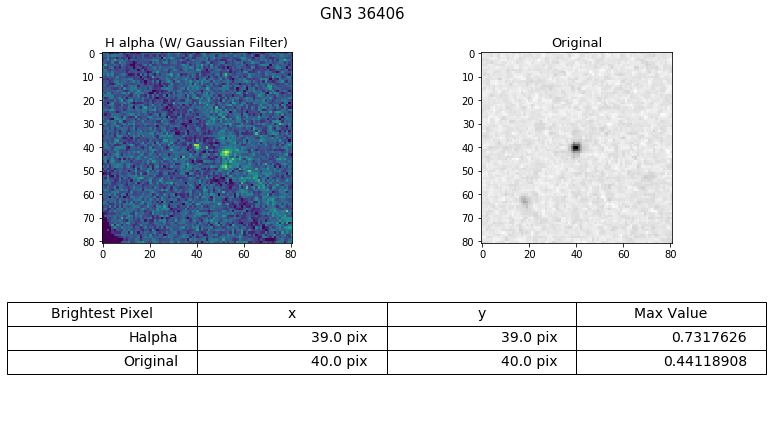

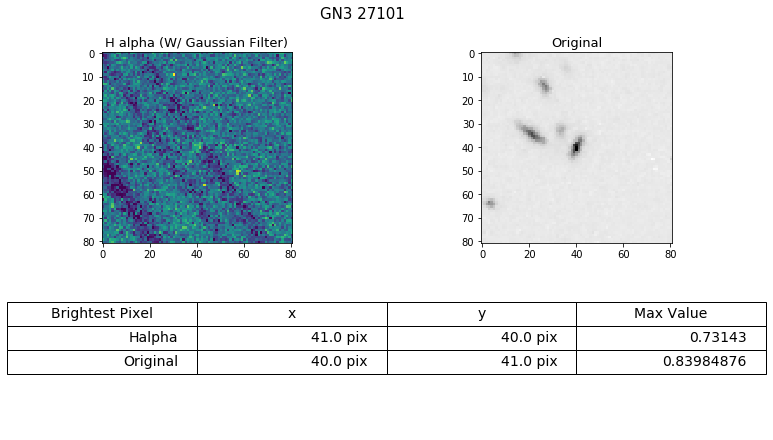

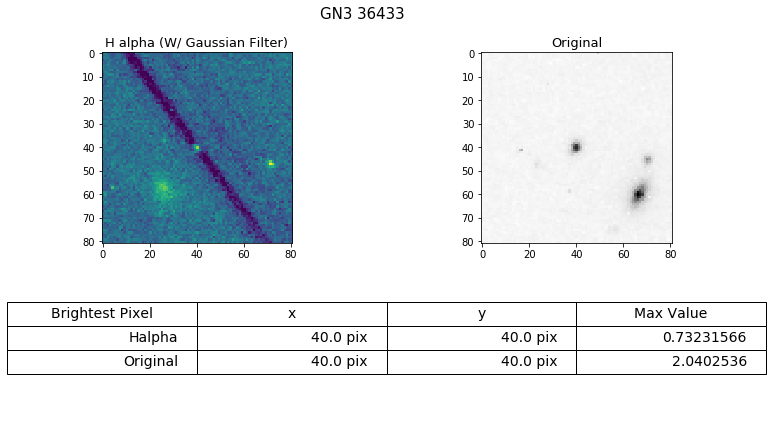

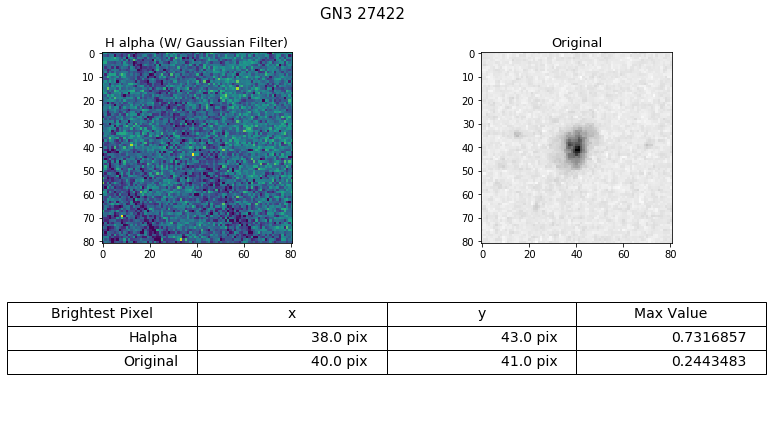

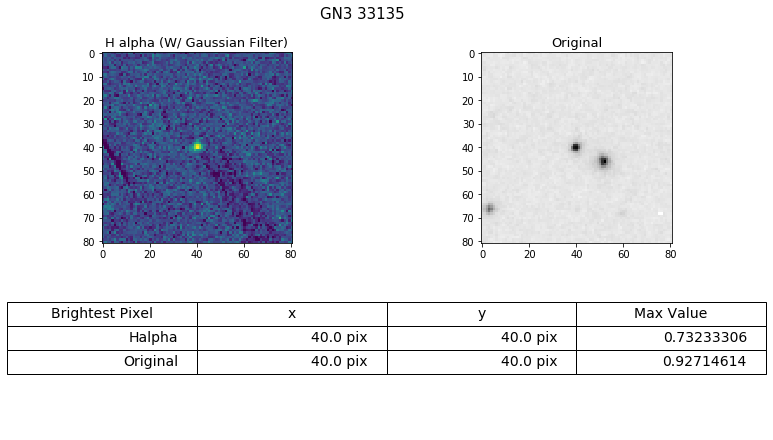

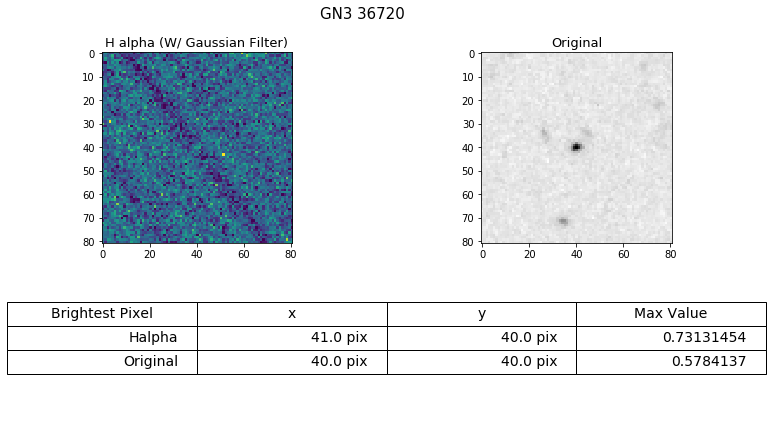

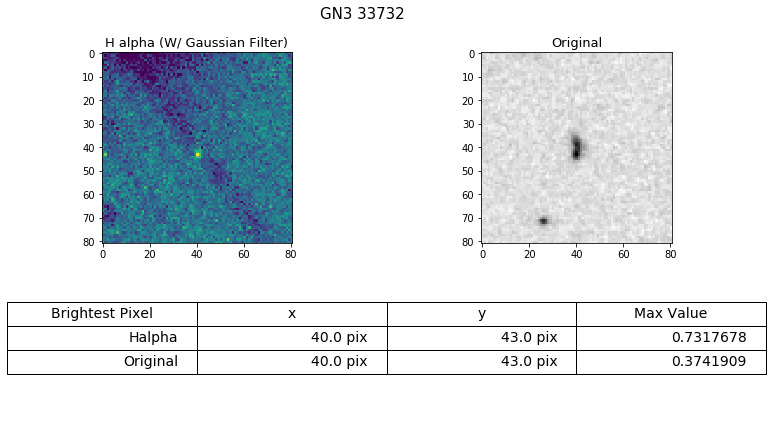

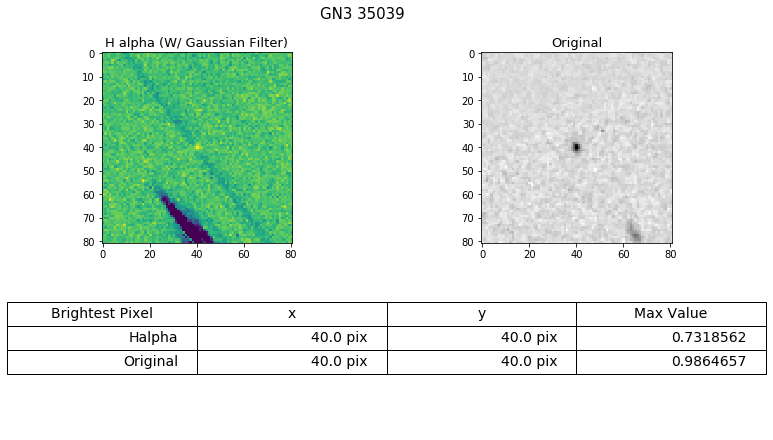

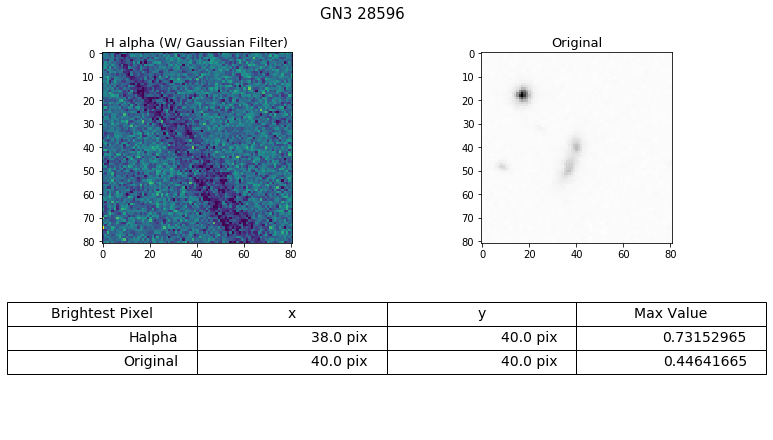

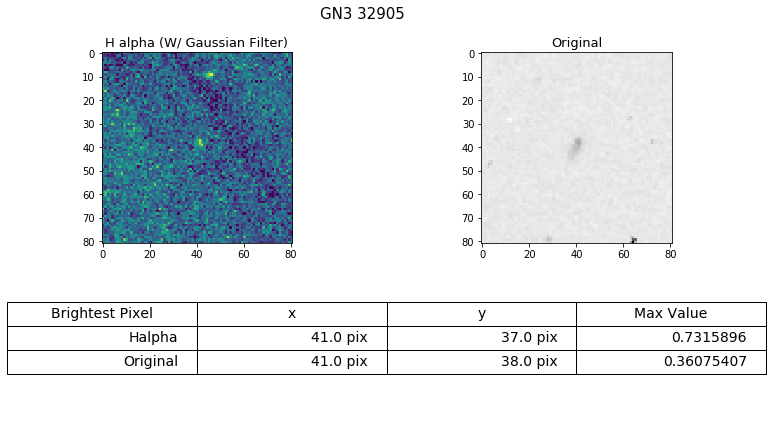

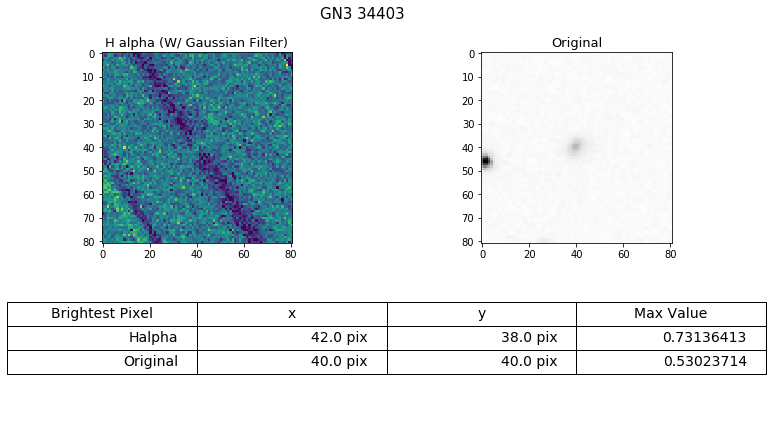

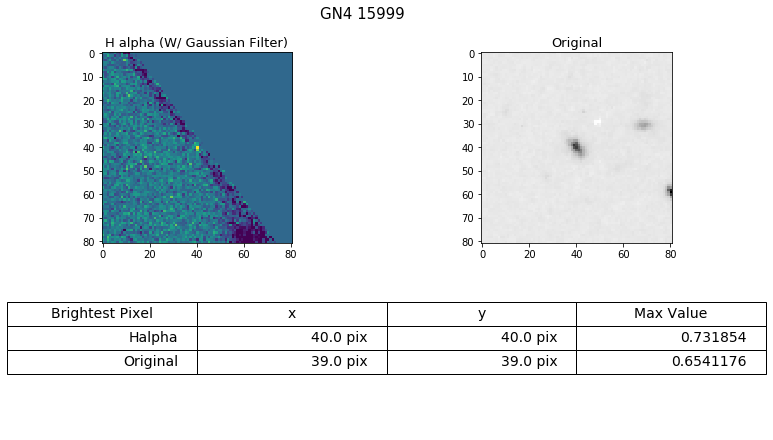

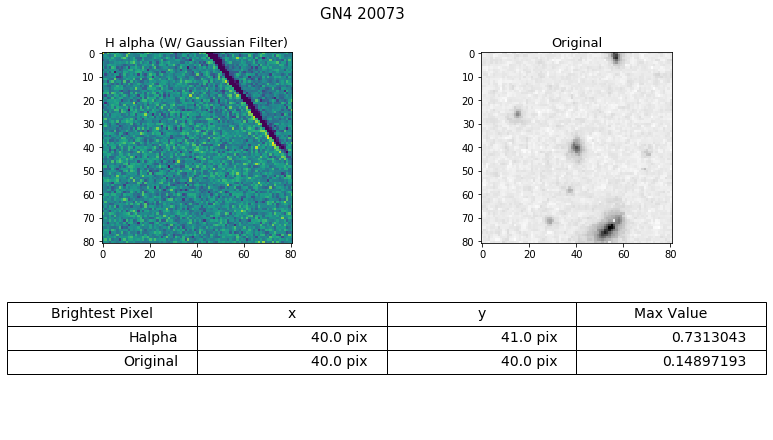

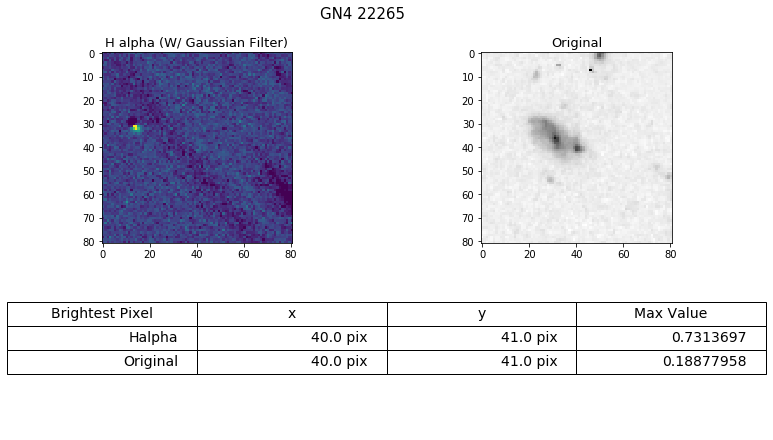

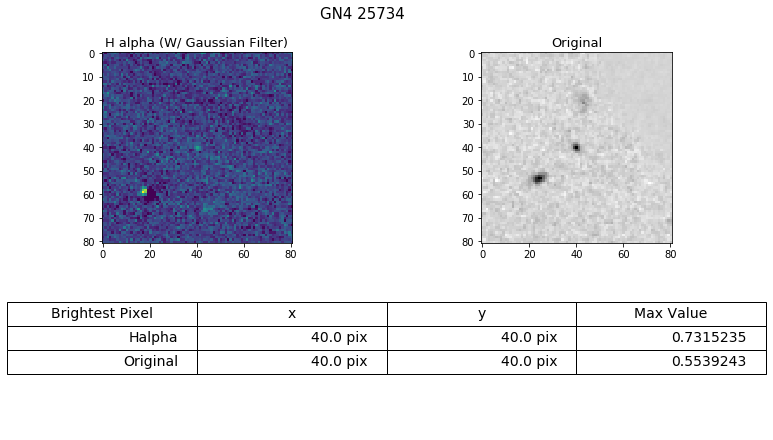

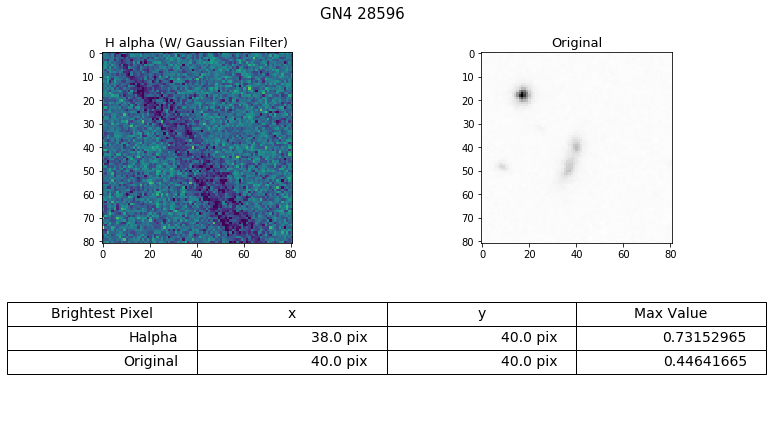

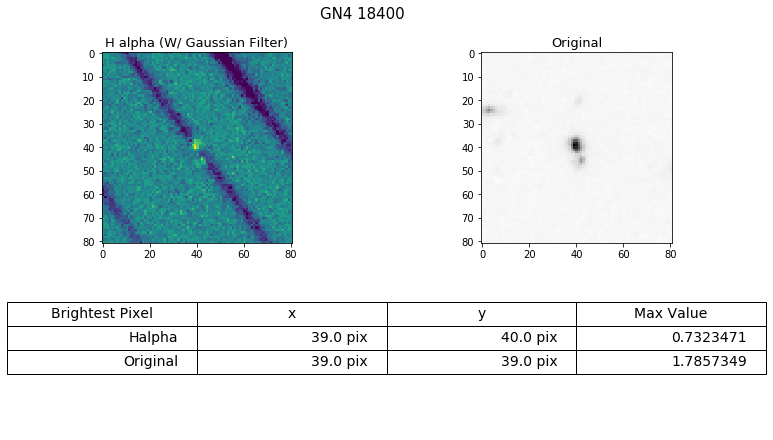

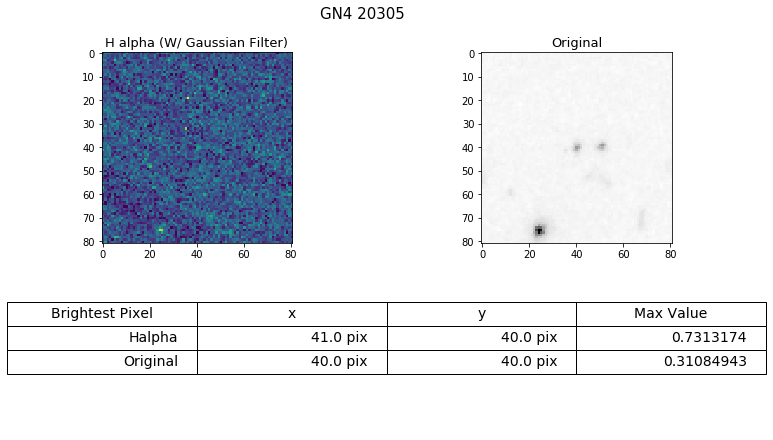

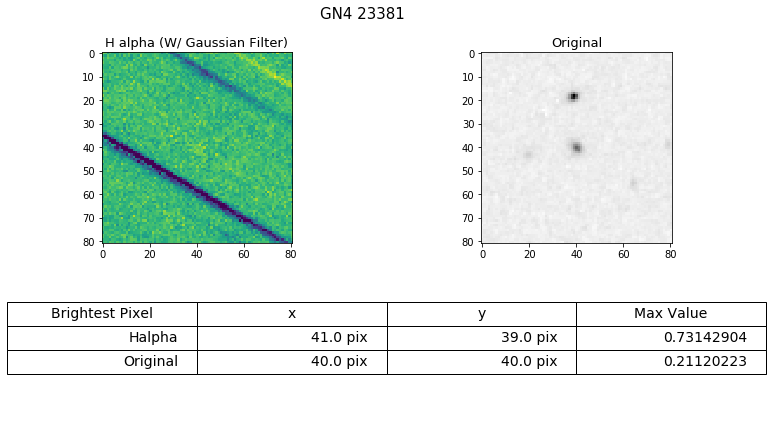

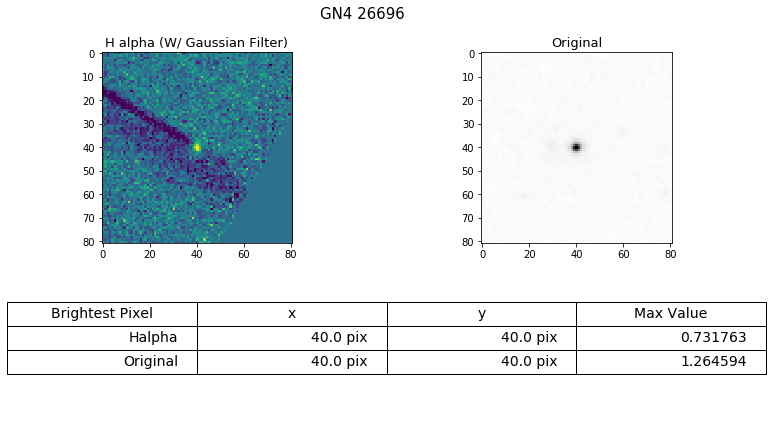

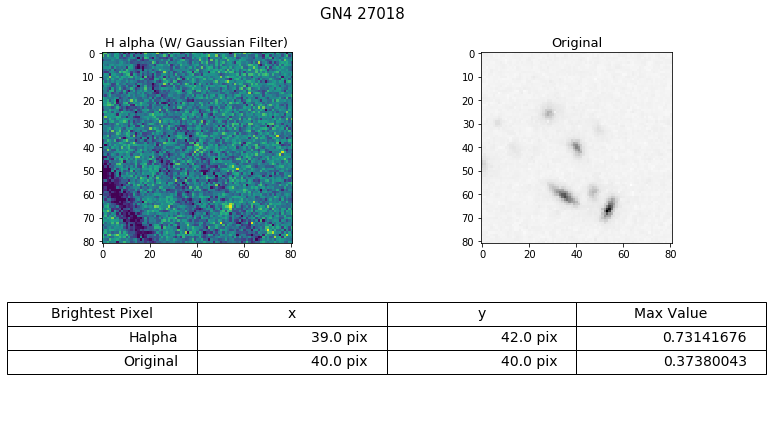

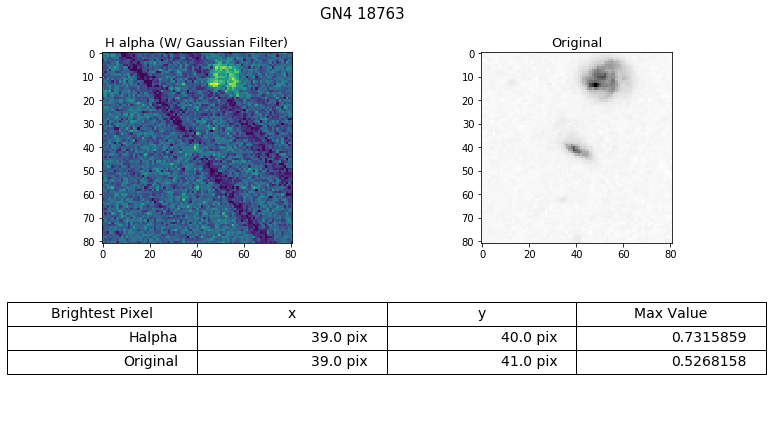

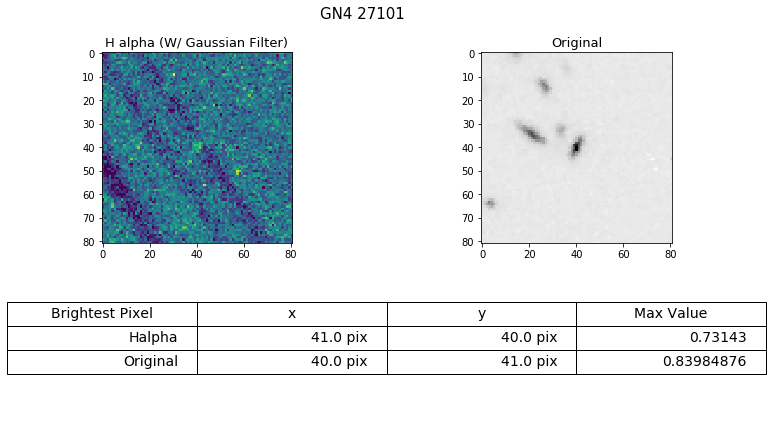

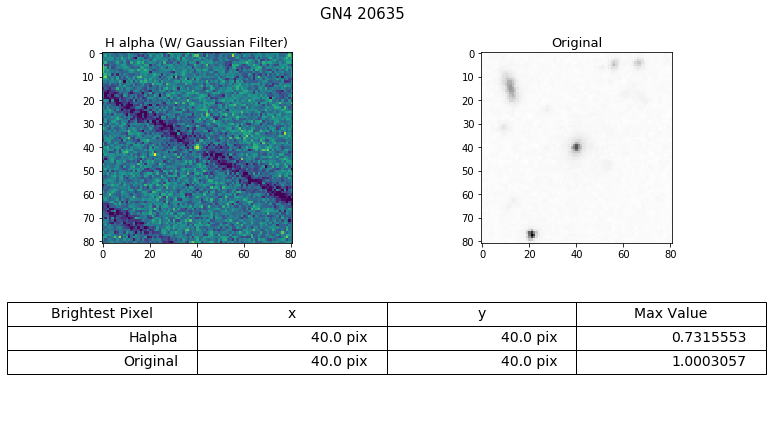

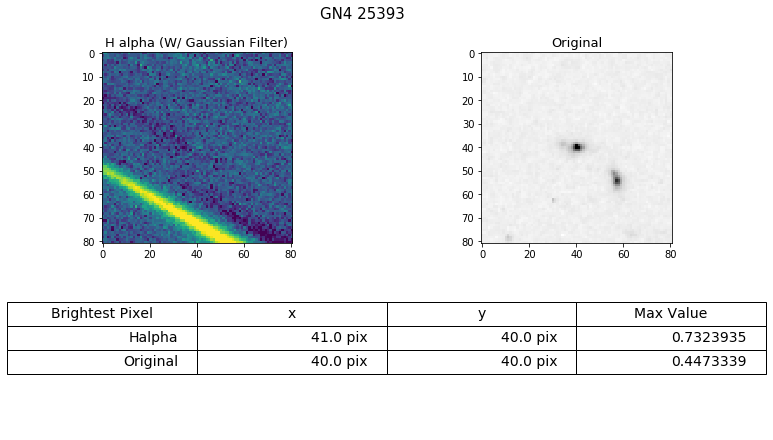

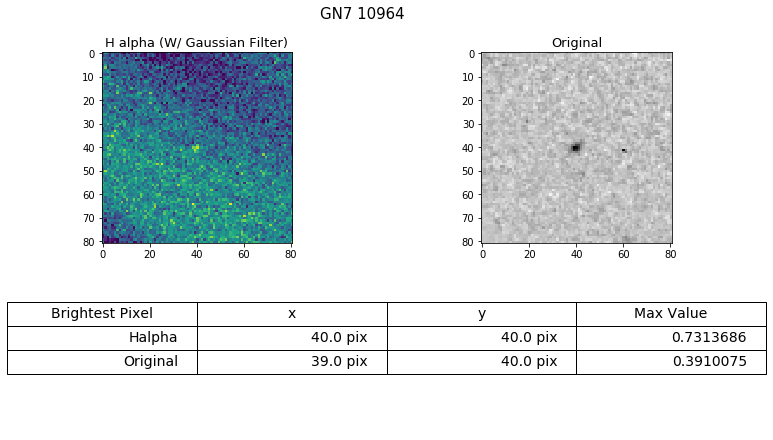

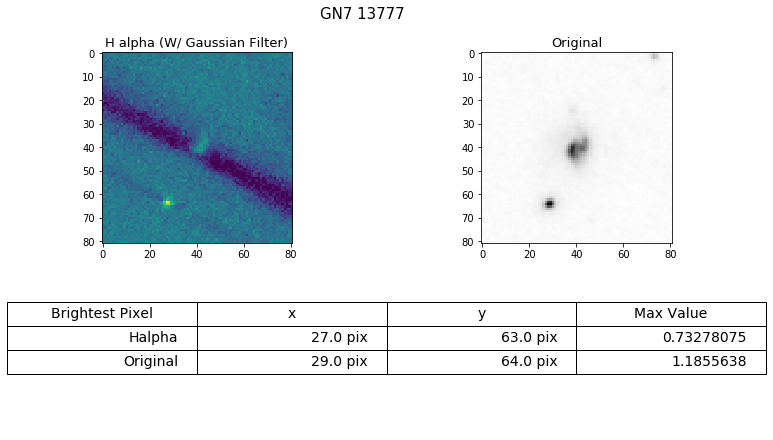

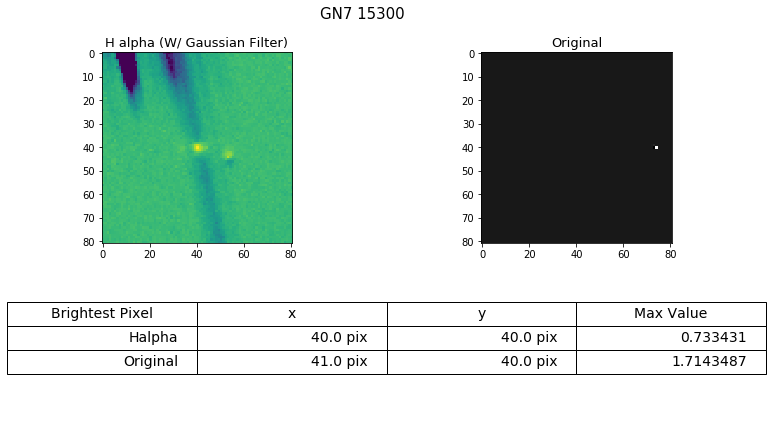

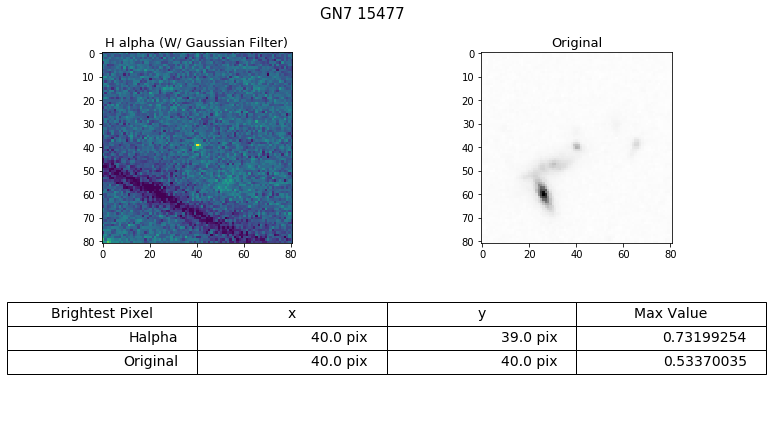

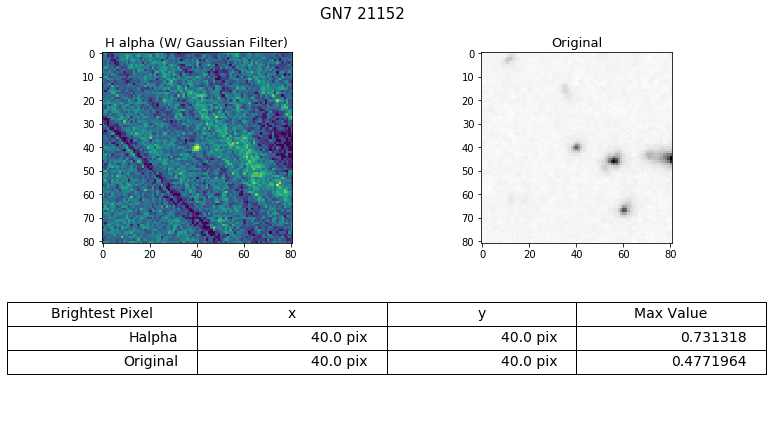

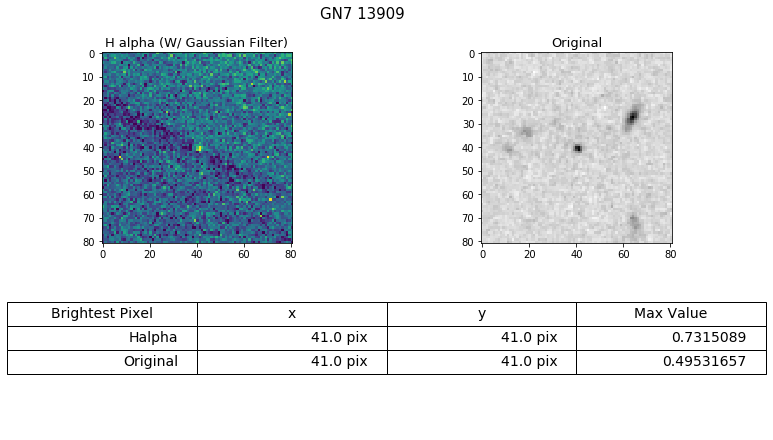

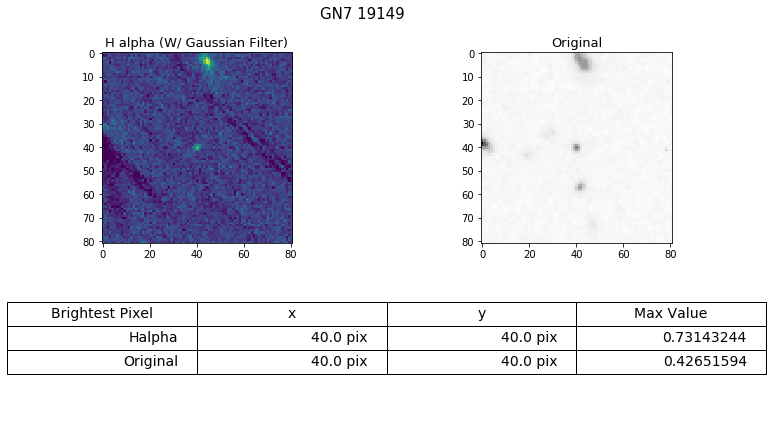

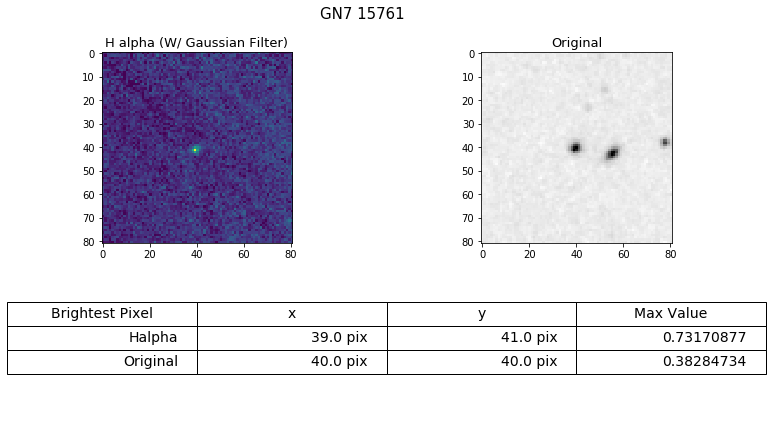

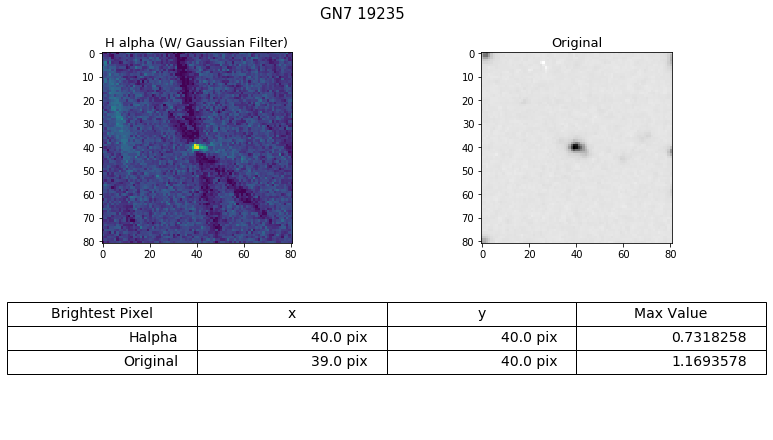

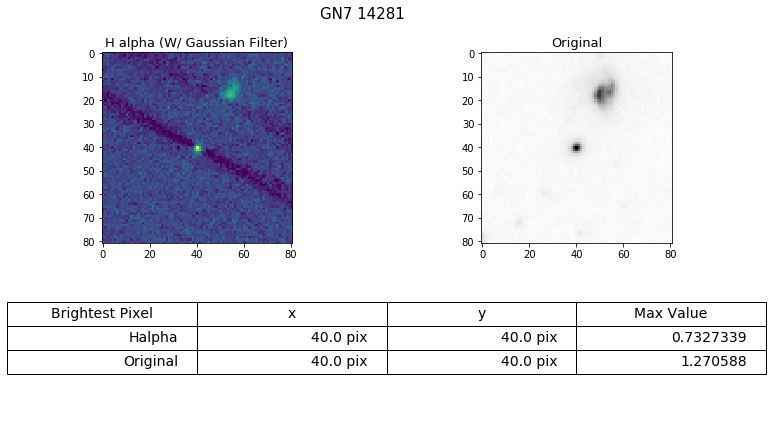

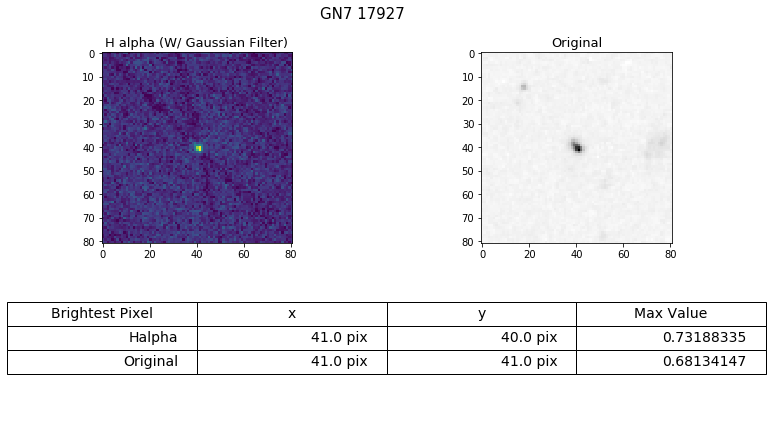

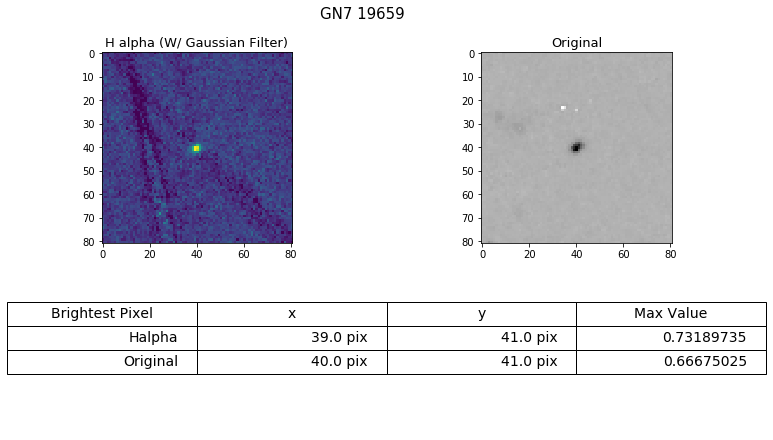

In [6]:
#Finalized Mergers
Sec = [GN1,GN2,GN3,GN4,GN5,GN7]
#Mergers W/ Issues
#Sec = [GN1_bad,GN2_bad,GN3_bad,GN4_bad,GN5_bad,GN7_bad]
Sec_name = ['GN1','GN2','GN3','GN4','GN5','GN7']

GN1_x_off,GN1_y_off,GN2_x_off,GN2_y_off,GN3_x_off,GN3_y_off = [],[],[],[],[],[]
GN4_x_off,GN4_y_off,GN5_x_off,GN5_y_off,GN7_x_off,GN7_y_off = [],[],[],[],[],[]
Std_Title = []
Max_Orig = []
Max_Ha = []
Gal_Orig = []
Gal_Ha = []
Field = []
ID = []

for i in range(len(Sec_name)):
#Listing all the Arrays for Each Section i.e. GN1
    RealData = []
    Mask = []
    im_med = []
    Halph = []
    Orig = []
    Title_fancy = []
    Title_save = []
    Ha_x = []
    Ha_y = []
    Orig_x = []
    Orig_y = []
    PlotData = []
    Plot_img = []
    Orig_plot = []
    
    for j in range(len(Sec[i])):
        GID = Sec[i][j]
        loc = Sec_name[i]
        
#Opening all the Fits Files
        H_a = fits.open('/Users/felixmartinez/Research/merger_detection/candidates/merger_candidates/'+loc+'/'+loc+'_'+str(GID)+
                                                                                                '.full.fits')
        Ha_fits = '/Users/felixmartinez/Research/merger_detection/candidates/merger_candidates/'+loc+'/'+loc+'_'+str(GID)+'.full.fits'
        Line = H_a['Line','Ha'].data     #Halpha data
        Continuum = H_a['Continuum','Ha'].data
        Contam = H_a['Contam','Ha'].data
        Raw = H_a['DSCI','F105W'].data
        
#Cropping and Correcting the data
        #Halph.append(Line[59:100,59:100] - Continuum[59:100,59:100] - Contam[59:100,59:100])  #Fixing the Errors on Halpha
        #Orig.append(Raw[59:100,59:100])
#The data uncropped
        Halph.append(Line[39:120,39:120] - Continuum[39:120,39:120] - Contam[39:120,39:120])  #Fixing the Errors on Halpha
        Orig.append(Raw[39:120,39:120])
        Title_fancy.append(loc + ' ' + str(GID))
        Title_save.append(loc + '_'+str(GID))
        
#X and Y Posistions of Galaxy on Seg Map
        Y,X = np.where(seg_N == GID)
        Z = np.array([Y,X]).T     #Gives the X and Y positions of Object in Y,X
        world = w.wcs_pix2world(Z,1)  #Gives RA and Dec Values of Object (May not be needed)
        
#Center Pixel of Ha on Seg Map
        RA = H_a[0].header['RA']                                
        DEC = H_a[0].header['DEC']    

        center = w.wcs_world2pix([[RA,DEC]],1)   #Finds the center pixels of the central RA and Dec of the Ha cutout
        hy = np.round(center[0][0])
        hx = np.round(center[0][1])
        center = np.array([int(hx),int(hy)])

#Making a Mask that is the Galaxy on Seg Map
        #seg_mask = np.array(seg_N[center[0]-20:center[0]+21,center[1]-20:center[1]+21]) #40x40 seg mask
        #seg_mask = np.array(seg_N[center[0]-30:center[0]+31,center[1]-30:center[1]+31]) #60x60 seg mask
        seg_mask = np.array(seg_N[center[0]-40:center[0]+41,center[1]-40:center[1]+41]) #80x80 seg mask
        seg_mask[seg_mask != GID] = 0
        seg_mask[seg_mask == GID] = 1
    
        Mask.append(np.array(seg_mask))
        
        Ha_img = Halph[j]
        Orig_img = Orig[j]
        
#Applying the Filter for the Galaxy Image
        #Halpha Image
        m=np.percentile(Ha_img,1.5)   #High Pass
        M=np.percentile(Ha_img,98.5)  #Low Pass
        if M < np.abs(m)*6:
            M = np.abs(m)*6
        PlotData.append(func.scaling_factor(Ha_img, m, M)) #Plotting image
        Plot_img.append(PlotData[j])  #No filter for the plotting of the img
        #Gal_img.append(Plot_img[j])
        
        #Origingal Image
        m=np.percentile(Orig_img,0)   #High Pass
        M=np.percentile(Orig_img,100)  #Low Pass
        if M < np.abs(m)*6:
            M = np.abs(m)*6
        Orig_plot.append(func.scaling_factor(Orig_img, m, M)) #Plotting image
        
#Applying the Segmentation Map Mask
        Ha_img[Mask[j] == 0]= -99
        Orig_img[Mask[j] == 0]= -99
        
#Applying the Filter for the Segmentation Map
        m=np.percentile(Ha_img,1.5)   #High Pass
        M=np.percentile(Ha_img,98.5)  #Low Pass
        if M < np.abs(m)*6:
            M = np.abs(m)*6
        RealData.append(func.scaling_factor(Ha_img, m, M))  #brightest pixel Real
        #im_med.append(Scaling_factor(Ha_img, m, M))  #brightest pixel Fake
        im_med.append(RealData[j])  #No Filter
        
#Finding the Position of the Brightest Pixel and its value
        Ha_position = np.argwhere(im_med[j] == im_med[j].max()) * u.pixel
        Ha_max_value = np.amax(im_med[j])

        Orig_position = np.argwhere(Orig_img == Orig_img.max()) * u.pixel
        Orig_max_value = np.amax(Orig_img) 
        
#Appending the x and y for the Histogram
        Ha_x.append(Ha_position[0][1])
        Ha_y.append(Ha_position[0][0])
        Orig_x.append(Orig_position[0][1])
        Orig_y.append(Orig_position[0][0])
        
#Filtering out Galaxies that are not within the inner 68%
        diff_x = Ha_x[j].value - Orig_x[j].value
        diff_y = Ha_y[j].value - Orig_y[j].value
        
        #if(round(xrange[x_low_3[0]],1) <= diff_x <= round(xrange[x_high_3[0]],1) and   #Within 3 Standard Deviations
        #   -2.5 <= diff_y <= round(xrange[y_high_3[0]],1)):
        if(-2.5 <= diff_x <= 2.5 and -2.5 <= diff_y <= 2.5):   #Within 3 Standard Deviations
            
            Gal_Ha.append(Ha_img)                    #H-alpha Values within 3 std
            Gal_Orig.append(Orig_img)                #Original Values within 3 std
            Std_Title.append(loc + ' ' + str(GID))   #Names of Gal within 3 std
            Max_Orig.append(Orig_max_value)          #Max original values within 3 std
            Max_Ha.append(Ha_max_value)              #Max Ha values within 3 std
            Field.append(loc)                        #Appending the location
            ID.append(GID)                           #Appending the Galaxy ID
            
#Appending the x and y offset Separetly by Section
            if loc == 'GN1':
                GN1_x_off.append(Ha_x[j].value - Orig_x[j].value)
                GN1_y_off.append(Ha_y[j].value - Orig_y[j].value)
            if loc == 'GN2':
                GN2_x_off.append(Ha_x[j].value - Orig_x[j].value)
                GN2_y_off.append(Ha_y[j].value - Orig_y[j].value)
            if loc == 'GN3':
                GN3_x_off.append(Ha_x[j].value - Orig_x[j].value)
                GN3_y_off.append(Ha_y[j].value - Orig_y[j].value)
            if loc == 'GN4':
                GN4_x_off.append(Ha_x[j].value - Orig_x[j].value)
                GN4_y_off.append(Ha_y[j].value - Orig_y[j].value)
            if loc == 'GN5':
                GN5_x_off.append(Ha_x[j].value - Orig_x[j].value)
                GN5_y_off.append(Ha_y[j].value - Orig_y[j].value)
            if loc == 'GN7':
                GN7_x_off.append(Ha_x[j].value - Orig_x[j].value)
                GN7_y_off.append(Ha_y[j].value - Orig_y[j].value)
            
        
#Making a table with Information of the Pixels location and values
            Test = {'Ha_x':pd.Series(Ha_position[0][1]), 'Ha_y':pd.Series(Ha_position[0][0]),
                    'Ha_max_value':pd.Series(Ha_max_value),'Orig_x':pd.Series(Orig_position[0][1]),
                    'Orig_y':pd.Series(Orig_position[0][0]),'Orig_max_value':pd.Series(Orig_max_value)}
            Position_table = pd.DataFrame(Test)    
            table_data=[['Halpha',Ha_position[0][1],Ha_position[0][0],Ha_max_value],
                        ['Original',Orig_position[0][1],Orig_position[0][0],Orig_max_value]]
        
#Plotting the Figures
            Labels=['Brightest Pixel','x','y','Max Value']
    
            plt.figure(figsize=[17,7])
            gs = GridSpec(2,4, wspace = -.499, hspace=0)
    
            plt.subplot(gs[0,1])    #Halpha Image
            plt.title('H alpha (W/ No Filter)',fontsize = 13)
            plt.imshow(Plot_img[j])

            plt.subplot(gs[0,3])    #Original Image
            plt.title('Original',fontsize = 13)
            plt.imshow(Orig_plot[j],cmap='binary')
    
            ax = plt.subplot(gs[1,1:])   #Tabel Below
            table = ax.table(table_data,colLabels=Labels,loc='center')
            table.set_fontsize(14)
            table.scale(1,2)
            ax.axis('off')
            
            plt.suptitle(Title_fancy[j],x=.57,y=.97,fontsize=15)
#Finalized Mergers Save Line
            #plt.savefig('/Users/felixmartinez/Research/Mergers_Images/'+loc+'/'+Title_save[j]+'.png',bbox_inches = 'tight')
#Mergers W/ Issues Save Line
            #plt.savefig('/Users/felixmartinez/Research/Mergers_Images/Bad_Ha/'+loc+'/'+Title_save[j]+'.png',bbox_inches = 'tight')
        else:
            pass

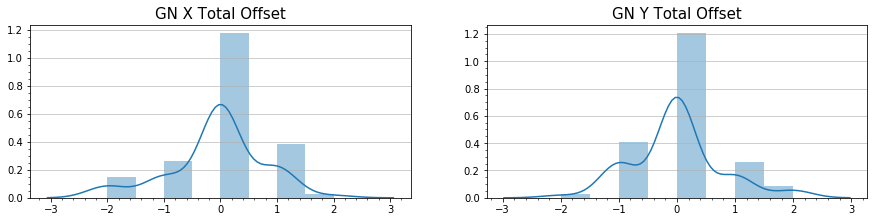

The total number of data points we have are: 68


In [7]:
import seaborn as sea
x_offset = []
y_offset = []

#Real data for Ha
for i in range(len(GN1_x_off)):
    x_offset.append(GN1_x_off[i])
    y_offset.append(GN1_y_off[i])

for i in range(len(GN2_x_off)):
    x_offset.append(GN2_x_off[i])
    y_offset.append(GN2_y_off[i])

for i in range(len(GN3_x_off)):
    x_offset.append(GN3_x_off[i])
    y_offset.append(GN3_y_off[i])

for i in range(len(GN4_x_off)):
    x_offset.append(GN4_x_off[i])
    y_offset.append(GN4_y_off[i])

for i in range(len(GN5_x_off)):
    x_offset.append(GN5_x_off[i])
    y_offset.append(GN5_y_off[i])

for i in range(len(GN7_x_off)):
    x_offset.append(GN7_x_off[i])
    y_offset.append(GN7_y_off[i])
    
plt.figure(figsize=[15,7])
    
plt.subplot(221)
plt.grid(axis = 'y',alpha = .75)
sea.distplot(x_offset)
plt.minorticks_on()
plt.title("GN X Total Offset", fontsize = 15)
#plt.savefig('/Users/felixmartinez/Research/Mergers_Images/x_offset.png',bbox_inches = 'tight')

plt.subplot(222)
plt.grid(axis = 'y',alpha = .75)
sea.distplot(y_offset)
plt.minorticks_on()
plt.title("GN Y Total Offset", fontsize = 15)
#plt.savefig('/Users/felixmartinez/Research/Mergers_Images/y_offset.png',bbox_inches = 'tight')

plt.show()

print("The total number of data points we have are: " + str(len(x_offset)))